In [ ]:
# ▸ 0  imports  ─────────────────────────────────────────
import pathlib, json, OS
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import ipywidgets as widgets
from IPython.display import display, clear_output
import os


Dropdown(description='Dataset:', layout=Layout(width='200px'), options=('europe', 'australia'), value='europe'…

Button(button_style='success', description='Plot TSI', icon='line-chart', style=ButtonStyle())

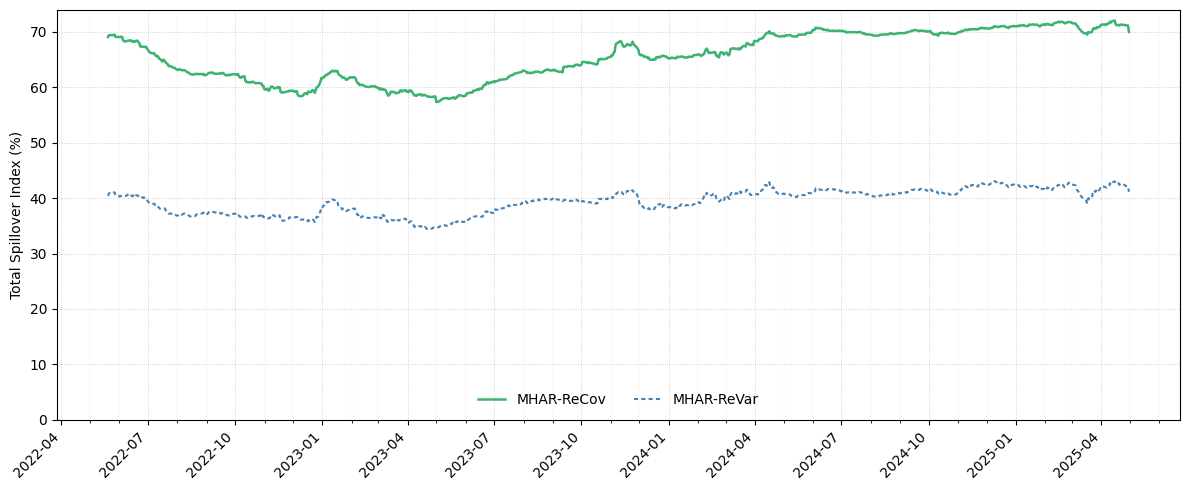

In [ ]:
# ────────────────────────────────────────────────────────────────
# Time-varying TSI  –  MHAR-ReVar  vs  MHAR-ReCov
# ────────────────────────────────────────────────────────────────


# make sure output folders exist
pathlib.Path("plots").mkdir(exist_ok=True)
latex_dir = pathlib.Path("latex_files"); latex_dir.mkdir(exist_ok=True)

# ▸ UI widgets -----------------------------------------------------
ds_selector = widgets.Dropdown(
    options=["europe", "australia"],
    value="europe",
    description="Dataset:",
    layout=widgets.Layout(width="200px"),
)
run_btn = widgets.Button(description="Plot TSI", button_style="success", icon="line-chart")

def do_plot(_):
    clear_output(wait=True)
    display(ds_selector, run_btn)

    region = ds_selector.value
    revar_path = f"parquet_files/rolling_tsi_mhar_revar_{region}.parquet"
    recov_path = f"parquet_files/rolling_tsi_mhar_recov_{region}.parquet"

    try:
        tsi_revar = pd.read_parquet(revar_path).rename(columns={"TSI": "MHAR-ReVar"})
        tsi_recov = pd.read_parquet(recov_path).rename(columns={"TSI": "MHAR-ReCov"})
    except FileNotFoundError as e:
        print(f"❌  File not found: {e.filename}")
        return

    df = tsi_recov.join(tsi_revar, how="inner")

    # average gap (ReCov – ReVar) over common span
    gap = (df["MHAR-ReCov"] - df["MHAR-ReVar"]).mean()
    print(f"Average gap (ReCov − ReVar) over {len(df)} obs = {gap:.2f} pp")

    # ▸ plot --------------------------------------------------------
    fig, ax = plt.subplots(figsize=(12, 5))

    # new colours
    col_recov = "mediumseagreen"   # lighter green  → solid line
    col_revar = "steelblue"        # blue (not purple) → dashed line

    ax.plot(df.index, df["MHAR-ReCov"],
            color=col_recov, linewidth=1.8, label="MHAR-ReCov")
    ax.plot(df.index, df["MHAR-ReVar"],
            color=col_revar, linewidth=1.5, linestyle="--",
            dashes=(2, 1.5), label="MHAR-ReVar")

    # date axis: quarterly major, monthly minor
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    for t in ax.get_xticklabels():
        t.set_rotation(45); t.set_ha("right")

    ax.set_ylabel("Total Spillover Index (%)")
    ax.set_xlabel("")
    ax.set_ylim(bottom=0)
    ax.legend(loc="lower center", ncol=2, frameon=False)

    # beautiful dotted grid
    ax.grid(True, which="major", linestyle=":", linewidth=0.6, alpha=0.7)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.3, alpha=0.4)

    plt.tight_layout()
    pdf_name = f"plots/tsi_gap_{region}.pdf"
    fig.savefig(pdf_name, bbox_inches="tight")
    plt.show()
    print(f"✓ Plot saved to {pdf_name}")

    # ▸ save metadata ----------------------------------------------
    meta = {
        "region": region,
        "gap_pp": float(gap),
        "n_obs":  int(len(df)),
        "start": df.index[0].strftime("%Y-%m-%d"),
        "end":   df.index[-1].strftime("%Y-%m-%d"),
    }
    meta_path = f"plots/tsi_gap_{region}_meta.json"
    pathlib.Path(meta_path).write_text(json.dumps(meta, indent=2))
    print(f"✓ Metadata written to {meta_path}")

    # ▸ LaTeX snippet ----------------------------------------------
    latex_code = rf"""
\begin{{figure}}[htbp]
  \centering
  \includegraphics[width=\textwidth]{{plots/tsi_gap_{region}.pdf}}
  \caption{{Time-varying Total Spillover Index (TSI) based on MHAR-ReVar
            (dashed purple) and MHAR-ReCov (solid green).\footnotemark}}
  \label{{fig:tsi_gap_{region}}}
\end{{figure}}
\footnotetext{{Average gap (MHAR-ReCov $-$ MHAR-ReVar) over the common sample
               period: \textbf{{{gap:.2f}}} percentage points.}}
"""
    tex_path = latex_dir / f"fig_tsi_gap_{region}.tex"
    tex_path.write_text(latex_code, encoding="utf-8")
    print(f"✓ LaTeX snippet written to {tex_path}\n")
    print(latex_code)

    # expose values for further use in the notebook
    do_plot.last_region = region
    do_plot.last_gap    = gap

run_btn.on_click(do_plot)
display(ds_selector, run_btn)


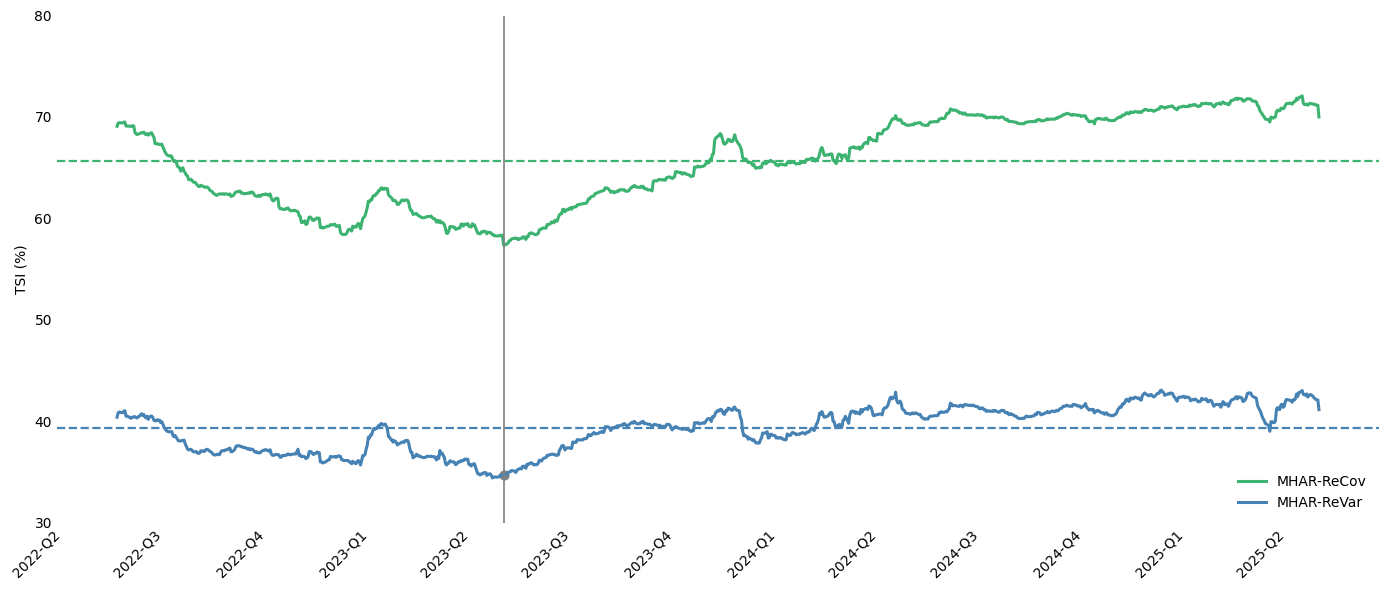

✓ Plot saved to plots/rolling_tsi_both_europe.png


In [17]:
from matplotlib.ticker import FuncFormatter

# ── choose data set ─────────────────────────────────────────────
region = ds_selector.value

revar_path = f"parquet_files/rolling_tsi_mhar_revar_{region}.parquet"
recov_path = f"parquet_files/rolling_tsi_mhar_recov_{region}.parquet"

tsi_revar = pd.read_parquet(revar_path).rename(columns={"TSI": "MHAR-ReVar"})
tsi_recov = pd.read_parquet(recov_path).rename(columns={"TSI": "MHAR-ReCov"})

# ── helper: quarterly label "YYYY-Qk" ───────────────────────────
def quarter_fmt(x, pos):
    dt = mdates.num2date(x)
    q = (dt.month - 1) // 3 + 1
    return f"{dt.year}-Q{q}"

# ── plot ────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 6))
fig.patch.set_alpha(0); ax.set_facecolor("none")

ax.plot(tsi_recov.index, tsi_recov["MHAR-ReCov"],
        lw=2.2, color="mediumseagreen", label="MHAR-ReCov")
ax.plot(tsi_revar.index, tsi_revar["MHAR-ReVar"],
        lw=2.2, color="steelblue",      label="MHAR-ReVar")

# mean lines
mean_recov = tsi_recov["MHAR-ReCov"].mean()
mean_revar = tsi_revar["MHAR-ReVar"].mean()
ax.axhline(mean_recov, ls="--", lw=1.6, color="mediumseagreen")
ax.axhline(mean_revar, ls="--", lw=1.6, color="steelblue")

# marker
mark_date = pd.Timestamp("2023-05-01")
if mark_date in tsi_revar.index:
    ax.axvline(mark_date, color="grey", lw=1.2)
    ax.scatter(mark_date, tsi_revar.loc[mark_date, "MHAR-ReVar"],
               color="grey", s=40)

# axis limits
ax.set_ylim(30, 80)
ax.set_ylabel("TSI (%)")

# ── quarterly major ticks, monthly minor ticks ─────────────────
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
ax.xaxis.set_major_formatter(FuncFormatter(quarter_fmt))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

for lbl in ax.get_xticklabels():
    lbl.set_rotation(45)
    lbl.set_ha("right")

# clean frame
ax.tick_params(axis="both", which="both", length=0)
for spine in ax.spines.values():
    spine.set_visible(False)

ax.legend(frameon=False, loc="lower right")
plt.tight_layout()

# save
os.makedirs("plots", exist_ok=True)
out_file = f"plots/rolling_tsi_both_{region}.png"
fig.savefig(out_file, dpi=300, transparent=True)
plt.show()
print(f"✓ Plot saved to {out_file}")
